In [0]:
!git clone https://github.com/soumik12345/ClassicaLSTM/

Cloning into 'ClassicaLSTM'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [0]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from music21 import instrument, note, stream, chord
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, CuDNNLSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
notes = np.load('ClassicaLSTM/notes.np.npy')
notes

array(['C4', '3.8', 'C4', ..., 'B-3', 'G3', 'E-2'], dtype='<U10')

In [0]:
n_vocab = len(set(notes))
print(n_vocab)

482


In [0]:
pitchnames = sorted(set(item for item in notes))
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

In [0]:
sequence_length, input_sequence, output_sequence = 100, [], []
for i in tqdm(range(0, len(notes) - sequence_length, 1)):
        sequence_in = notes[i : i + sequence_length]
        sequence_out = notes[i + sequence_length]
        input_sequence.append([note_to_int[char] for char in sequence_in])
        output_sequence.append(note_to_int[sequence_out])

100%|██████████| 515657/515657 [00:20<00:00, 25309.68it/s]


In [0]:
n_patterns = len(input_sequence)
print(n_patterns)

515657


In [0]:
normalized_input = np.reshape(input_sequence, (n_patterns, sequence_length, 1)) / float(n_vocab)
encoded_output = to_categorical(output_sequence)
normalized_input.shape, encoded_output.shape

((515657, 100, 1), (515657, 482))

In [0]:
def rnn(sequence_length, n_vocab):
    model = Sequential([
        CuDNNLSTM(512, input_shape = (sequence_length, 1), return_sequences = True),
        Dropout(0.3),
        CuDNNLSTM(512, return_sequences = True),
        Dropout(0.3),
        CuDNNLSTM(512),
        Dense(256),
        Dropout(0.3),
        Dense(n_vocab, activation = 'softmax')
    ])
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'rmsprop')
    return model

In [0]:
model = rnn(sequence_length, n_vocab)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 100, 512)          1054720   
_________________________________________________________________
dropout (Dropout)            (None, 100, 512)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 512)          2101248   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 512)               2101248   
_________________________________________________________________
dense (Dense)        

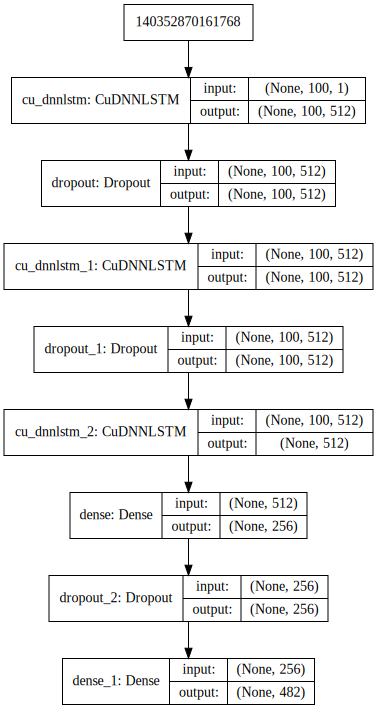

In [0]:
SVG(model_to_dot(model, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [0]:
checkpoint = ModelCheckpoint(
    './gdrive/My Drive/lstm_music_generation/model_checkpoints/improved_weights_{epoch:02d}.hdf5',
    monitor = 'loss',
    verbose = 1,
    save_best_only = True,
    mode = 'min'
)
model.fit(normalized_input, output_sequence, epochs = 200, batch_size = 64, callbacks = [checkpoint])

Epoch 1/200
515648/515657 [============================>.] - ETA: 0s - loss: 4.7646
Epoch 00001: loss improved from inf to 4.76457, saving model to ./gdrive/My Drive/lstm_music_generation/model_checkpoints/improved_weights_01.hdf5
515657/515657 [==============================] - 680s 1ms/sample - loss: 4.7646
Epoch 2/200
515648/515657 [============================>.] - ETA: 0s - loss: 4.7595
Epoch 00002: loss improved from 4.76457 to 4.75953, saving model to ./gdrive/My Drive/lstm_music_generation/model_checkpoints/improved_weights_02.hdf5
515657/515657 [==============================] - 677s 1ms/sample - loss: 4.7595
Epoch 3/200
515648/515657 [============================>.] - ETA: 0s - loss: 4.7677
Epoch 00003: loss did not improve from 4.75953
515657/515657 [==============================] - 677s 1ms/sample - loss: 4.7677
Epoch 4/200
515648/515657 [============================>.] - ETA: 0s - loss: 4.7762
Epoch 00004: loss did not improve from 4.75953
515657/515657 [=================